In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prettytable import PrettyTable

In [2]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score,KFold
from sklearn.gaussian_process import GaussianProcessRegressor,kernels
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.ensemble import GradientBoostingRegressor,RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
from src.models.constants import Constants
from src.models import util

In [5]:
plt.style.use('seaborn-v0_8-talk')
cmap = plt.get_cmap("tab10")
raw_dir = "C:/Users/Hermans_Desktop1/OneDrive - UW-Madison/Documents/Research/2022-P4 (Pt DH ML)/iterative_catalyst_design/data/raw"
processed_dir = "C:/Users/Hermans_Desktop1/OneDrive - UW-Madison/Documents/Research/2022-P4 (Pt DH ML)/iterative_catalyst_design/data/processed"
n_map = {1:"Base",2:"Thru Rnd 1",3:"Thru Rnd 2",4:"Thru Rnd 3",5:"Thru Rnd 4",6:"Thru Rnd 5",7:"Thru Rnd 6-GP"}
seed=0
fname = f'3-averaged_Round{5}-Standardized.csv' #Data through Round 4
f = processed_dir+"/"+fname
df = pd.read_csv(f,index_col=0)
df.head()

,Pt,Sn,Ga,Fe,Cu,Ca,Mn,Zn,k_d,Y0,lifetime_yield,Y_pc,sqrtY0Y_pc,lifetime_yield_sd,Y_pc_sd,sqrtY0Y_pc_sd
0,1,0,0,0,0,0,0,0,0.009888,0.079167,7.906378,7.122892,0.749430,1.391523,0.117528,0.012366
1,1,0,0,0,0,1,0,0,0.006639,0.052747,7.944507,6.330042,0.577835,1.398233,0.104446,0.009534
2,1,0,0,0,0,4,0,0,0.005610,0.211910,37.771519,27.945063,2.433485,6.647787,0.461094,0.040152
3,1,0,0,0,0,8,0,0,0.006555,0.162041,24.720653,19.593907,1.781855,4.350835,0.323299,0.029401
4,1,0,0,0,1,0,0,0,0.006305,0.211454,33.538397,26.152810,2.351620,5.902758,0.431521,0.038802


In [6]:
X,y=util.get_Xy(df)
print(f'Num Samples: {X.shape[0]}, Num Features: {X.shape[1]}')
X.head()


Num Samples: 50, Num Features: 7


,Sn,Ga,Fe,Cu,Ca,diversity,loading
0,0,0,0,0,0,0,0
1,0,0,0,0,1,1,1
2,0,0,0,0,4,1,4
3,0,0,0,0,8,1,8
4,0,0,0,1,0,1,1


3-Fold Cross Validation r2-Values
+---------+--------+-------+
|  Model  |  Mean  |   SD  |
+---------+--------+-------+
|   KNN   | 0.245  | 0.231 |
|   GPR   | -0.054 | 0.187 |
|  Linear | 0.132  | 0.306 |
| RidgeCV | 0.195  | 0.276 |
| LassoCV | -0.032 | 0.164 |
|   ENCV  | -0.016 | 0.186 |
|   RFR   | 0.507  | 0.137 |
|   GBR   |  0.42  | 0.211 |
|   SVR   | 0.307  | 0.259 |
+---------+--------+-------+


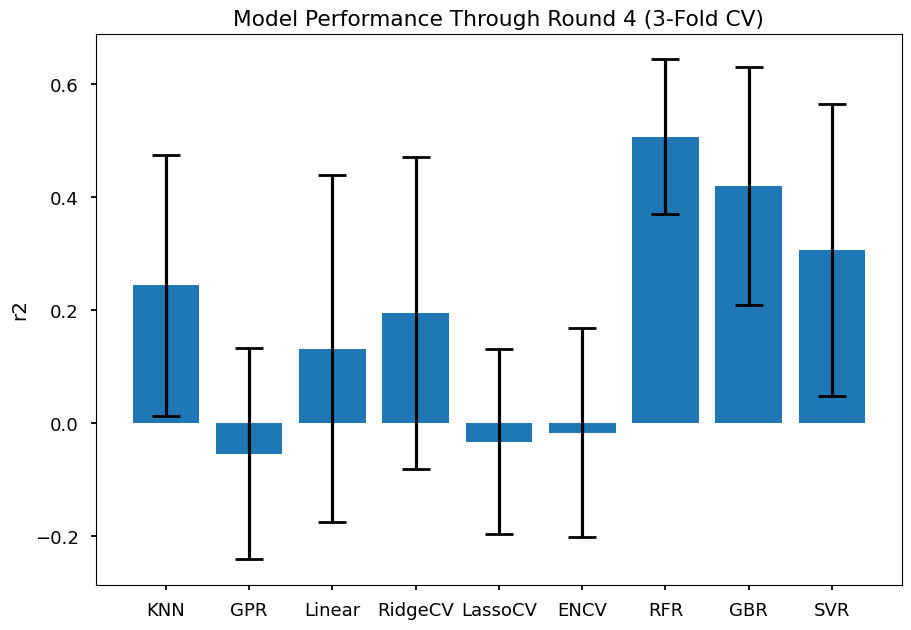

5-Fold Cross Validation r2-Values
+---------+--------+-------+
|  Model  |  Mean  |   SD  |
+---------+--------+-------+
|   KNN   | 0.285  | 0.263 |
|   GPR   | -0.102 | 1.012 |
|  Linear | 0.248  | 0.233 |
| RidgeCV | 0.272  | 0.241 |
| LassoCV | 0.261  | 0.242 |
|   ENCV  | 0.174  | 0.264 |
|   RFR   | 0.443  | 0.162 |
|   GBR   | 0.325  | 0.217 |
|   SVR   | 0.373  | 0.171 |
+---------+--------+-------+


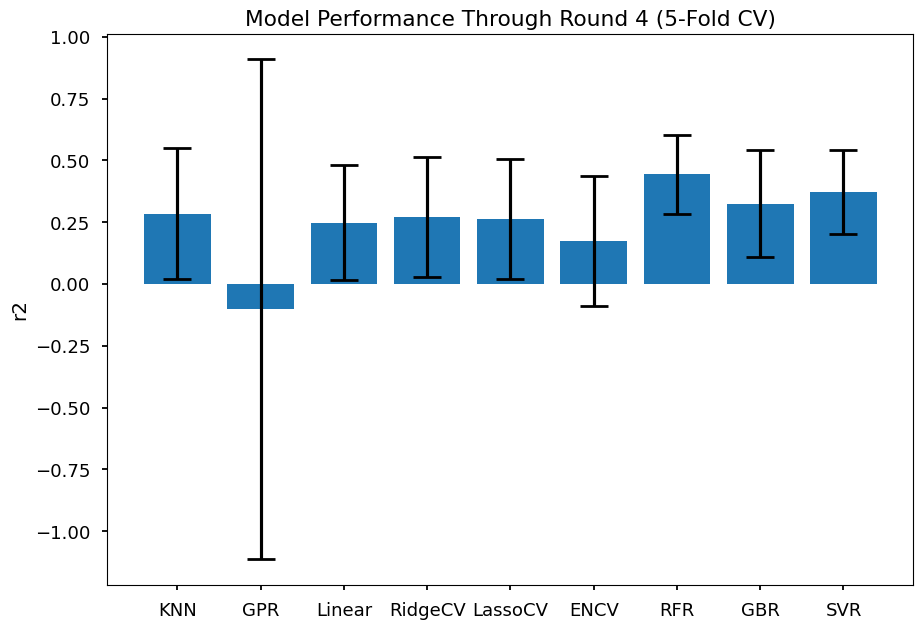

10-Fold Cross Validation r2-Values
+---------+-------+-------+
|  Model  |  Mean |   SD  |
+---------+-------+-------+
|   KNN   | 0.089 | 0.403 |
|   GPR   | 0.308 | 0.381 |
|  Linear |  0.28 | 0.341 |
| RidgeCV | 0.278 | 0.348 |
| LassoCV |  0.23 | 0.325 |
|   ENCV  | 0.197 |  0.33 |
|   RFR   | 0.361 | 0.451 |
|   GBR   | 0.314 | 0.364 |
|   SVR   | 0.343 | 0.228 |
+---------+-------+-------+


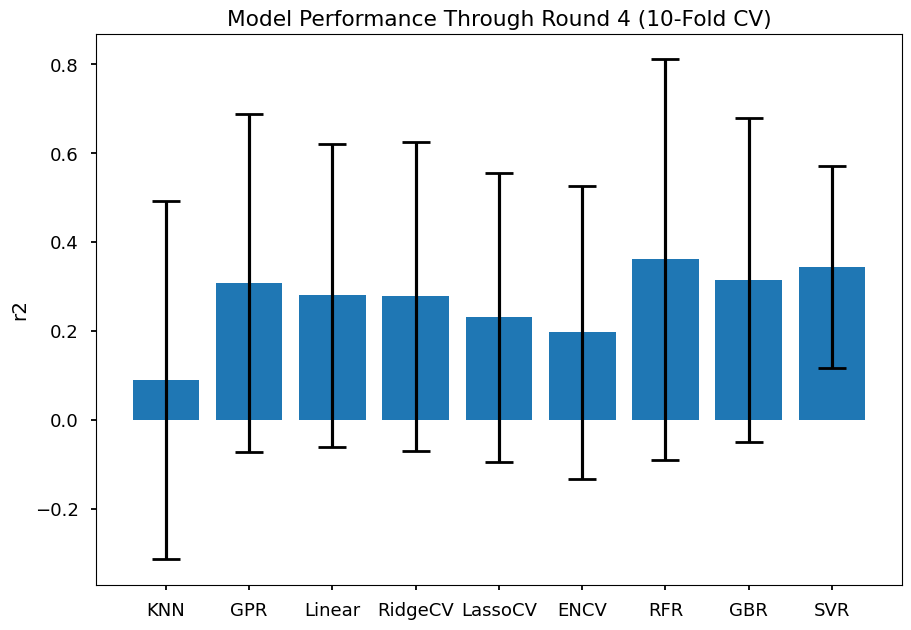

In [77]:
#testing models
score='r2'
for K in [3,5,10]:
    print(f'{K}-Fold Cross Validation {score}-Values')
    kfold = KFold(n_splits=K,random_state=seed,shuffle=True)
    
    models = [('KNN',KNeighborsRegressor()),
              ('GPR',GaussianProcessRegressor(kernel=1*kernels.RBF(length_scale=1.0,length_scale_bounds=(1e-2,1e2)),n_restarts_optimizer=5,random_state=seed)),
              ('Linear',LinearRegression()),
              ('RidgeCV',RidgeCV()),
              ('LassoCV',LassoCV(random_state=seed)),
              ('ENCV',ElasticNetCV(random_state=seed)),
              ('RFR',RandomForestRegressor(random_state=seed)),
              ('GBR',GradientBoostingRegressor(random_state=seed)),
              ('SVR',SVR())
             ]
    
    
               
    t = PrettyTable(['Model','Mean','SD'])
    names = []
    means = []
    stds = []
    for name,model in models:
        pipeline = make_pipeline(model)
        scores=cross_val_score(pipeline,X,y=y,cv=kfold,scoring=score)
        row=[name,round(scores.mean(),3),round(scores.std(),3)]
        t.add_row([name,round(scores.mean(),3),round(scores.std(),3)])
        names.append(name)
        means.append(scores.mean())
        stds.append(scores.std())
    
        
    print(t)
    x = [i for i in range(len(names))]
    plt.bar(x,means,yerr=stds,tick_label=names,error_kw={'capsize':10,'capthick':2})
    plt.ylabel(score)
    plt.title(f'Model Performance Through Round 4 ({K}-Fold CV)')
    #plt.savefig(f'./figures/model_performance_{score}_{K}-Fold.png',dpi=600,bbox_inches='tight')
    plt.show()
    with open(f'./figures/model_performance_{score}_{K}-Fold.csv','w') as f:
        f.write(t.get_csv_string())

In [41]:
pipeline

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('gradientboostingregressor',
                 GradientBoostingRegressor(random_state=0))])

# 2) Creating parity plots for all models

In [6]:
model_arr = {}
models = [('KNN',KNeighborsRegressor()),
          ('GPR',GaussianProcessRegressor(kernel=1*kernels.RBF(length_scale=1.0,length_scale_bounds=(1e-2,1e2)),n_restarts_optimizer=5,random_state=seed)),
          ('Linear',LinearRegression()),
          ('RidgeCV',RidgeCV()),
          ('LassoCV',LassoCV(random_state=seed)),
          ('ENCV',ElasticNetCV(random_state=seed)),
          ('RFR',RandomForestRegressor(random_state=seed)),
          ('GBR',GradientBoostingRegressor(random_state=seed)),
          ('SVR',SVR())
         ]
for name,model in models:

    X,y=util.get_Xy(df)
    n = X.shape[0]    
    X = X.to_numpy()
    y = y.to_numpy()
    y_preds = []
    y_actuals = []
    loo = KFold(n_splits=n)
    for train_index,test_index in loo.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        pipeline = make_pipeline(StandardScaler(),model)
        pipeline.fit(X_train,y_train)
        y_pred = pipeline.predict(X_test)
        y_preds.append(y_pred[0])
        y_actuals.append(y_test[0])
    model_arr[name]={"y_preds":y_preds,"y_actuals":y_actuals}

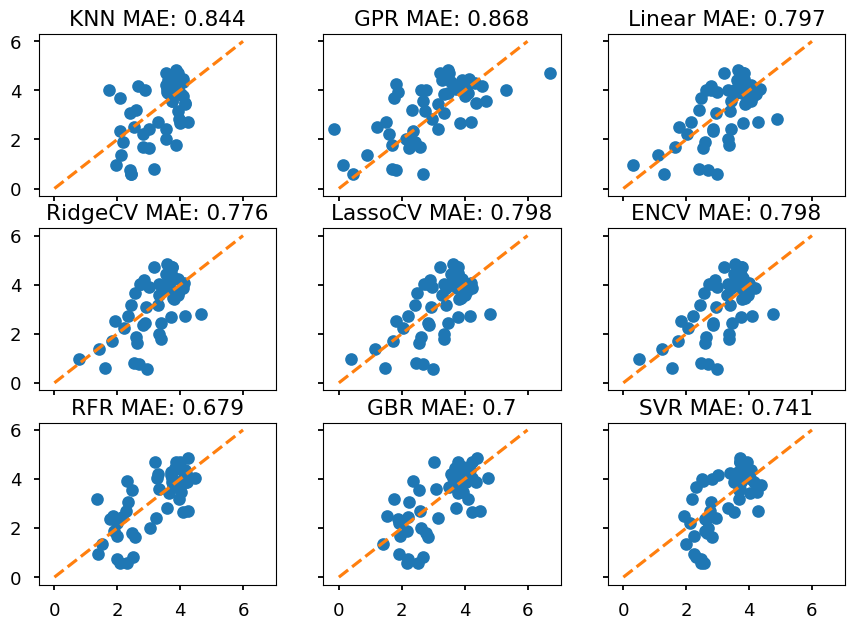

In [10]:
fig,axs = plt.subplots(3,3,sharex=True,sharey=True)
k=0
for i in range(3):
    for j in range(3):
        name = models[k][0]
        y_preds = model_arr[name]["y_preds"]
        y_actuals = model_arr[name]["y_actuals"]
        axs[i,j].plot(y_preds,y_actuals,'o')
        axs[i,j].set_title(f'{name} MAE: {mean_absolute_error(y_actuals,y_preds):.3}')
        axs[i,j].plot(np.arange(7),np.arange(7),'--')
        k += 1
#plt.savefig('./figures/model-loo-cv-subplots.png',dpi=600,bbox_inches='tight')

# 3) Parity Plots Through Round 6-GP

In [12]:
plt.style.use('seaborn-v0_8-talk')
cmap = plt.get_cmap("tab10")
raw_dir = "C:/Users/Hermans_Desktop1/OneDrive - UW-Madison/Documents/Research/2022-P4 (Pt DH ML)/iterative_catalyst_design/data/raw"
processed_dir = "C:/Users/Hermans_Desktop1/OneDrive - UW-Madison/Documents/Research/2022-P4 (Pt DH ML)/iterative_catalyst_design/data/processed"
n_map = {1:"Base",2:"Thru Rnd 1",3:"Thru Rnd 2",4:"Thru Rnd 3",5:"Thru Rnd 4",6:"Thru Rnd 5",7:"Thru Rnd 6-GP"}
seed=0
fname = f'3-averaged_Round{7}-Standardized.csv' #Data through Round 4
f = processed_dir+"/"+fname
df = pd.read_csv(f,index_col=0)
X,y=util.get_Xy(df)
print(f'Num Samples: {X.shape[0]}, Num Features: {X.shape[1]}')
print(f'Range of y: {max(y)-min(y):.3} Mean of y: {y.mean():.3} SD of y: {y.std():.3}')
X.head()

Num Samples: 68, Num Features: 7
Range of y: 4.29 Mean of y: 3.37 SD of y: 1.18


,Sn,Ga,Fe,Cu,Ca,diversity,loading
0,0.0,0.0,0.0,0.0,0.0,0,0.0
1,0.0,0.0,0.0,0.0,1.0,1,1.0
2,0.0,0.0,0.0,0.0,4.0,1,4.0
3,0.0,0.0,0.0,0.0,8.0,1,8.0
4,0.0,0.0,0.0,1.0,0.0,1,1.0


In [13]:
model_arr = {}
models = [('KNN',KNeighborsRegressor()),
          ('GPR',GaussianProcessRegressor(kernel=1*kernels.RBF(length_scale=1.0,length_scale_bounds=(1e-2,1e2)),n_restarts_optimizer=5,random_state=seed)),
          ('Linear',LinearRegression()),
          ('RidgeCV',RidgeCV()),
          ('LassoCV',LassoCV(random_state=seed)),
          ('ENCV',ElasticNetCV(random_state=seed)),
          ('RFR',RandomForestRegressor(random_state=seed)),
          ('GBR',GradientBoostingRegressor(random_state=seed)),
          ('SVR',SVR())
         ]
for name,model in models:

    X,y=util.get_Xy(df)
    n = X.shape[0]    
    X = X.to_numpy()
    y = y.to_numpy()
    y_preds = []
    y_actuals = []
    loo = KFold(n_splits=n)
    for train_index,test_index in loo.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        pipeline = make_pipeline(StandardScaler(),model)
        pipeline.fit(X_train,y_train)
        y_pred = pipeline.predict(X_test)
        y_preds.append(y_pred[0])
        y_actuals.append(y_test[0])
    model_arr[name]={"y_preds":y_preds,"y_actuals":y_actuals}

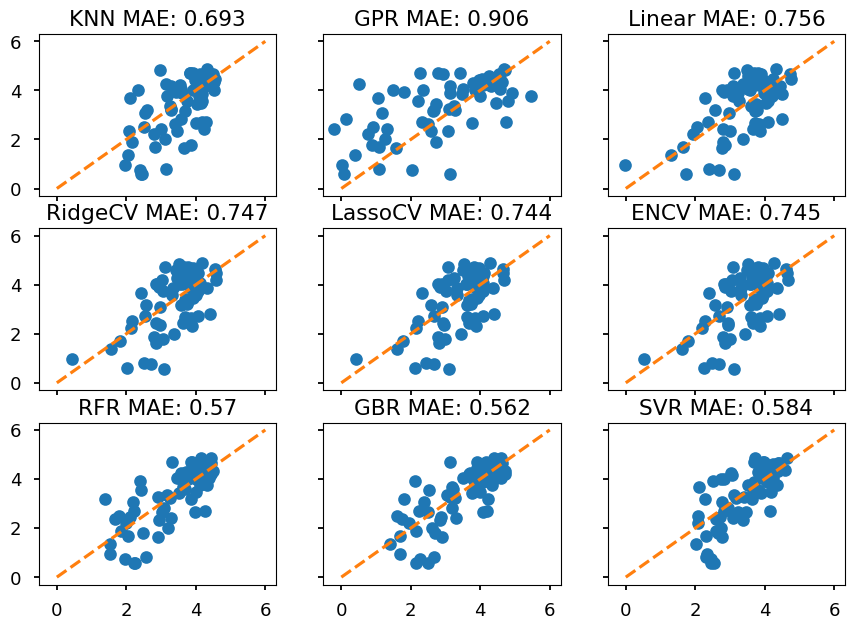

In [14]:
fig,axs = plt.subplots(3,3,sharex=True,sharey=True)
k=0
for i in range(3):
    for j in range(3):
        name = models[k][0]
        y_preds = model_arr[name]["y_preds"]
        y_actuals = model_arr[name]["y_actuals"]
        axs[i,j].plot(y_preds,y_actuals,'o')
        axs[i,j].set_title(f'{name} MAE: {mean_absolute_error(y_actuals,y_preds):.3}')
        axs[i,j].plot(np.arange(7),np.arange(7),'--')
        k += 1
#plt.savefig('./figures/model-loo-cv-subplots.png',dpi=600,bbox_inches='tight')